In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/sample_submission_gfvA5FD.csv
/kaggle/input/test.csv
/kaggle/input/train.csv


In [2]:
train = pd.read_csv('/kaggle/input/train.csv')
test = pd.read_csv('/kaggle/input/test.csv')

In [3]:
train.head()

,id,label,tweet
0,1,0,@user when a father is dysfunctional and is s...
1,2,0,@user @user thanks for #lyft credit i can't us...
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in ...
4,5,0,factsguide: society now #motivation


In [4]:
tweets = train['tweet'].values
labels = train['label'].values
test_input = test['tweet'].values
test_label = list()

# **Text PreProcessing**

In [5]:
from nltk.corpus import stopwords
StopWords = stopwords.words('english')

In [6]:
appos = {"aren't" : "are not", "can't" : "cannot", "couldn't" : "could not", "didn't" : "did not", "doesn't" : "does not",
"don't" : "do not", "hadn't" : "had not", "hasn't" : "has not", "haven't" : "have not", "he'd" : "he would",
"he'll" : "he will", "he's" : "he is", "i'd" : "I would", "i'd" : "I had", "i'll" : "I will", "i'm" : "I am",
"isn't" : "is not","it's" : "it is", "it'll":"it will", "i've" : "I have", "let's" : "let us", "mightn't" : "might not",
"mustn't" : "must not", "shan't" : "shall not", "she'd" : "she would", "she'll" : "she will", "she's" : "she is",
"shouldn't" : "should not", "that's" : "that is", "there's" : "there is", "they'd" : "they would", "they'll" : "they will",
"they're" : "they are", "they've" : "they have", "we'd" : "we would", "we're" : "we are", "weren't" : "were not",
"we've" : "we have", "what'll" : "what will","what're" : "what are","what's" : "what is", "what've" : "what have",
"where's" : "where is", "who'd" : "who would", "who'll" : "who will", "who're" : "who are", "who's" : "who is",
"who've" : "who have", "won't" : "will not", "wouldn't" : "would not", "you'd" : "you would", "you'll" : "you will",
"you're" : "you are", "you've" : "you have", "'re": " are", "wasn't": "was not", "we'll":" will", "didn't": "did not"}

In [7]:
from string import punctuation
def tweet_format(tweets):
    all_tweets = list()
    for text in tweets:
        lower_case = text.lower()
        words = lower_case.split()
        formatted = [appos[word] if word in appos else word for word in words]
        formatted_test = list()
        for word in formatted:
            if word not in StopWords:
                formatted_test.append(word)
        formatted = " ".join(formatted_test)
        punct_text = "".join([ch for ch in formatted if ch not in punctuation])
        all_tweets.append(punct_text)
    all_text = " ".join(all_tweets)
    all_words = all_text.split()
    for i in range(len(all_tweets)):
        if all_tweets[i].startswith("user"):
            all_tweets[i] = all_tweets[i].replace("user", '')
    return all_tweets, all_words

# **Creating own embeddings based on the corpus**

In [8]:
from collections import Counter 
# Counts the occurence of each word
all_tweets, all_words = tweet_format(tweets)
count_words = Counter(all_words)
total_words = len(all_words)
sorted_words = count_words.most_common(total_words)
vocab_to_int = {w:i+1 for i,(w,c) in enumerate(sorted_words)}

In [9]:
all_tweets[0]

' father dysfunctional selfish drags kids dysfunction run'

In [10]:
def encode_tweets(tweets):
    '''
    encodes review into an array
    '''
    All_tweets = list()
    for text in tweets:
        text = text.lower()
        text = "".join([ch for ch in text if ch not in punctuation])
        All_tweets.append(text)
    encoded_tweets = list()
    for tweet in All_tweets:
        encoded_tweet = list()
        for word in tweet.split():
            if word not in vocab_to_int.keys():
                encoded_tweet.append(0)
            else:
                encoded_tweet.append(vocab_to_int[word])
        encoded_tweets.append(encoded_tweet)
    return encoded_tweets

In [11]:
def pad_sequences(encoded_tweets, sequence_length = 30):
    ''' 
    Return features of tweet_ints, where each review is padded with 0's or truncated to the input seq_length.
    ensures all tweets have the same length
    '''
    features = np.zeros((len(encoded_tweets), sequence_length), dtype=int)
    
    for i, tweet in enumerate(encoded_tweets):
        tweet_len = len(tweet)
        if (tweet_len <= sequence_length):
            zeros = list(np.zeros(sequence_length-tweet_len))
            new = zeros + tweet
        else:
            new = tweet[:sequence_length]
        features[i,:] = np.array(new)
    return features

In [12]:
def preprocess(tweets):
    """
    This Function will tranform reviews in to model readable form
    """
    formated_tweets, all_words = tweet_format(tweets)
    encoded_tweets = encode_tweets(formated_tweets)
    features = pad_sequences(encoded_tweets, 30)
    return features

# **Analyzing tweet length**

In [13]:
import matplotlib.pyplot as plt
%matplotlib inline

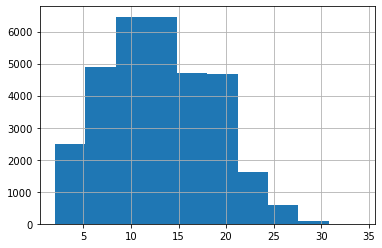

count    31962.000000
mean        12.938145
std          5.461209
min          2.000000
25%          9.000000
50%         12.000000
75%         17.000000
max         34.000000
dtype: float64

In [14]:
encoded_tweets = encode_tweets(tweets)
tweet_len = [len(encoded_tweet) for encoded_tweet in encoded_tweets]
pd.Series(tweet_len).hist()
plt.show()
pd.Series(tweet_len).describe()

# **Splitting the Data and Building the Model**

In [15]:
#splitting data into 90%train and 10%validation
features = preprocess(tweets)
x_train = features[:int(0.90 * len(features))]
y_train = labels[:int(0.90 * len(features))]
x_valid = features[int(0.90 * len(features)):]
y_valid = labels[int(0.90 * len(features)):]
print(len(y_train), len(y_valid))

28765 3197


In [16]:
import torch
from torch.utils.data import DataLoader, TensorDataset

#creating Tensor Dataset
#torch.Tensor has default dtype float32 but from_numpy() inherits a default dtype of int32
train_data = TensorDataset(torch.from_numpy(x_train), torch.from_numpy(y_train))
valid_data = TensorDataset(torch.from_numpy(x_valid), torch.from_numpy(y_valid))

#data loader
batch_size = 64
train_loader = DataLoader(train_data, batch_size = batch_size, shuffle = True, drop_last = True)
valid_loader = DataLoader(valid_data, batch_size = batch_size, shuffle = True, drop_last = True)

In [17]:
#obtain one batch of training data
dataiter = iter(train_loader)
sample_x, sample_y = dataiter.next()
print('Sample input size: ', sample_x.size()) # batch_size, seq_length
print('Sample input: \n', sample_x)
print()
print('Sample label size: ', sample_y.size()) # batch_size
print('Sample label: \n', sample_y)

Sample input size:  torch.Size([64, 30])
Sample input: 
 tensor([[    0,     0,     0,  ...,  6537,    54,     2],
        [    0,     0,     0,  ...,    87,   880, 16803],
        [    0,     0,     0,  ...,   102,    19,    82],
        ...,
        [    0,     0,     0,  ...,   960, 21502,   287],
        [    0,     0,     0,  ...,    85,   306,    65],
        [    0,     0,     0,  ..., 28491, 28492,    15]])

Sample label size:  torch.Size([64])
Sample label: 
 tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1])


In [18]:
#creating the LSTM class
import torch.nn as nn 

class CustomLSTM(nn.Module):
    '''
    this will be the LSTM model which will be used to perform the sentiment analysis
    '''
    def __init__(self, vocab_size, output_size, embedding_dim, hidden_dim, n_layers, drop_prob = 0.5):
        '''
        initialize the model by setting up the layers
        '''
        super().__init__()
        self.output_size = output_size
        self.n_layers = n_layers
        self.hidden_dim = hidden_dim
        
        #embedding and LSTM layers
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, n_layers, dropout = drop_prob, batch_first = True)
        
        #dropout layer
        self.dropout = nn.Dropout(0.3)
        
        #Linear and sigmoid layer
        self.fc1 = nn.Linear(hidden_dim, 64)
        self.fc2 = nn.Linear(64, 16)
        self.fc3 = nn.Linear(16, output_size)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x, hidden):
        '''
        performing forward pass of our model on some input and hidden state
        '''
        batch_size = x.size()
        
        #Embedding and LSTM
        embedd = self.embedding(x)
        lstm_out, hidden = self.lstm(embedd, hidden)
        
        #stacking up lstm output
        lstm_out = lstm_out.contiguous().view(-1, self.hidden_dim)
        
        #dropout and fully connected layers
        out = self.dropout(lstm_out)
        out = self.fc1(out)
        out = self.dropout(out)
        out = self.fc2(out)
        out = self.dropout(out)
        out = self.fc3(out)
        sig_out = self.sigmoid(out)
        
        sig_out = sig_out.view(batch_size, -1)
        sig_out = sig_out[:, -1]
        
        return sig_out, hidden
    
    def init_hidden(self, batch_size):
        """
        Initialize Hidden STATE
        """
        # Create two new tensors with sizes n_layers x batch_size x hidden_dim,
        # initialized to zero, for hidden state and cell state of LSTM
        weight = next(self.parameters()).data
        
        if (train_on_gpu):
            hidden = (weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().cuda(),
                  weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().cuda())
        else:
            hidden = (weight.new(self.n_layers, batch_size, self.hidden_dim).zero_(),
                      weight.new(self.n_layers, batch_size, self.hidden_dim).zero_())
        
        return hidden

In [19]:
vocab_size = len(vocab_to_int) + 1
output_size = 1
embedding_dim = 400
hidden_dim = 256
n_layers = 2

net = CustomLSTM(vocab_size, output_size, embedding_dim, hidden_dim, n_layers)
print(net)

CustomLSTM(
  (embedding): Embedding(47507, 400)
  (lstm): LSTM(400, 256, num_layers=2, batch_first=True, dropout=0.5)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc1): Linear(in_features=256, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=16, bias=True)
  (fc3): Linear(in_features=16, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


In [20]:
#loss and optimization functions
lr = 0.001

criterion = nn.BCELoss()
optimizer = torch.optim.Adam(net.parameters(), lr = lr)

#checking if GPU is available
train_on_gpu = torch.cuda.is_available()

epochs = 5
counter = 0
print_every = 100
clip = 5 #gradient clipping

if(train_on_gpu):
    net.cuda()

net.train()
for e in range(epochs):
    #initialize the hidden state (h0, c0)
    train_loss = []
    h = net.init_hidden(batch_size)
    
    #loop through each batch
    for inputs, labels in train_loader:
        counter += 1
        
        if(train_on_gpu):
            inputs = inputs.cuda()
            labels = labels.cuda()
            
        # Creating new variables for the hidden state, otherwise we'd backprop through the entire training history
        h = tuple([each.data for each in h])
        
        #sets gradients of all parameters to zero initially
        net.zero_grad()
        
        output, h = net(inputs, h)
        
        #calculating loss and performing backprop
        loss = criterion(output.squeeze(), labels.float())
        train_loss.append(loss)
        loss.backward()
        
        #clip_grad_norm helps prevent grad explosion
        nn.utils.clip_grad_norm(net.parameters(), clip)
        optimizer.step()
        
        #loss stats
        if counter % print_every == 0:
            val_h = net.init_hidden(batch_size)
            val_losses = []
            net.eval()
            for inputs, labels in valid_loader:
                
                #creating new variables for the hidden state, otherwise  we'd backprop through the entire training history
                val_h = tuple([each.data for each in val_h])
                
                inputs, labels = inputs.cuda(), labels.cuda()
                output, val_h = net(inputs, val_h)
                val_loss = criterion(output.squeeze(), labels.float())
                
                val_losses.append(val_loss.item())
            
            net.train()
            print("Epoch: {}/{}...".format(e+1, epochs),
                  "Step: {}...".format(counter),
                  "Loss: {:.6f}...".format(loss.item()),
                  "Val Loss: {:.6f}".format(np.mean(val_losses)))

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:46: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.


Epoch: 1/5... Step: 100... Loss: 0.254657... Val Loss: 0.243587
Epoch: 1/5... Step: 200... Loss: 0.245408... Val Loss: 0.181150
Epoch: 1/5... Step: 300... Loss: 0.187299... Val Loss: 0.162870
Epoch: 1/5... Step: 400... Loss: 0.121939... Val Loss: 0.148698
Epoch: 2/5... Step: 500... Loss: 0.055599... Val Loss: 0.149855
Epoch: 2/5... Step: 600... Loss: 0.023647... Val Loss: 0.160886
Epoch: 2/5... Step: 700... Loss: 0.027614... Val Loss: 0.149210
Epoch: 2/5... Step: 800... Loss: 0.111229... Val Loss: 0.154323
Epoch: 3/5... Step: 900... Loss: 0.021073... Val Loss: 0.130737
Epoch: 3/5... Step: 1000... Loss: 0.002213... Val Loss: 0.195183
Epoch: 3/5... Step: 1100... Loss: 0.019400... Val Loss: 0.166082
Epoch: 3/5... Step: 1200... Loss: 0.001922... Val Loss: 0.208097
Epoch: 3/5... Step: 1300... Loss: 0.013425... Val Loss: 0.202327
Epoch: 4/5... Step: 1400... Loss: 0.029879... Val Loss: 0.212110
Epoch: 4/5... Step: 1500... Loss: 0.013186... Val Loss: 0.251458
Epoch: 4/5... Step: 1600... Loss: 

In [73]:
def test_model(test_input):
    output_list = list()
    batch_size = 64
    net.eval()
    with torch.no_grad():
        test_tweet = preprocess(test_input)
        for tweet in test_tweet:
            #convert to tensor to pass into the model
            feature_tensor = torch.from_numpy(tweet).view(1, -1)
            if(train_on_gpu):
                feature_tensor = feature_tensor.cuda()
            batch_size = feature_tensor.size(0)
            #initialize hidden state
            h = net.init_hidden(batch_size)
            #get the output from the model
            output, h = net(feature_tensor, h)
            pred = torch.round(output.squeeze())
            output_list.append(pred)
        test_labels = [int(i.data.cpu().numpy()) for i in output_list]
        return test_labels

In [74]:
test_labels = test_model(test_input)

In [75]:
output = pd.DataFrame()
output['id'] = test['id']
output['label'] = test_labels

In [76]:
output

,id,label
0,31963,0
1,31964,0
2,31965,0
3,31966,0
4,31967,0
...,...,...
17192,49155,1
17193,49156,0
17194,49157,0
17195,49158,0


In [77]:
output.to_csv('submission.csv', index=False)